# Paris - City of Light
## Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## I. Introduction: Business Problem <a name="introduction"></a>

In this project we will try to help the **Mayor of Paris** and his colleagues nearby Paris to adjust the **City policies** in order to encourage **social diversity** and to increase the **attractiveness of the neighborhoods**.

Paris is a tremendous city of 2 million inhabitants, with a very rich offer of culture, history but also gastronomy and nature. Around, the "Ile de France" region is the biggest european region in terms of population and GDP. Real estate is quite expensive, and there are important discrepancies among the 20 Paris districts ("Arrondissements") and the cities which are very close to Paris.

Our project will focus on East Paris (10 arrondissements) and 10 surrounding cities close to East Paris. Data collection and interpretation will focus on two distinct parts:
- first, we will examine the **real estate** price per "Arrondissement" or city, based on the available public data of Real Estate transactions. We will calculate the average price per square meter per city.
- second, we will find the most **popular venues** and segment the neighborhoods according to the typology of their venues. Of course, Foursquera will be used to collect the associated data.

Once we have the Real Estate prices associated to each Quartier and the Venues profile, we will try to find a **correlation** between the two types of data and describe what is the **venue segment associated with a "expensive", "medium" and "low price" neighborhood**.

We will than use then our data science powers to make some recommendation for the Mayor in order to adjust the City Policies. Particularly, we will try to find **what kind of venues** should be encouraged in order to increase the **attractiveness of the low price neighborhoods**.

## II. Data <a name="data"></a>

Let's start by importing the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### II.1 The geographical region we will study

The geographical region we will focus on is East Paris and the cities close to paris on it's East side.

Let's start by having a look on this part of map.

In [2]:
def paris_east ():
    latitude = 48.8534
    longitude = 2.4488
    # create Paris east Map map and display it
    return folium.Map(location=[latitude, longitude], zoom_start=13)

# display the map of East Paris
paris_east_map = paris_east()

paris_east_map

Let's mark on the map the boundaries of the **Cities** and **"Arrondissements"** we are interested in. 

We will use for this the GeoJson file available on https://france-geojson.gregoiredavid.fr

In [3]:
def paris_cities (paris_map):

    #windows version of wget
    import wget

    url = 'https://france-geojson.gregoiredavid.fr/repo/regions/ile-de-france/communes-ile-de-france.geojson'
    filename = wget.download(url)

    # !wget --quiet https://france-geojson.gregoiredavid.fr/repo/regions/ile-de-france/communes-ile-de-france.geojson -O communes-ile-de-france.geojson
    
    communes_ile_de_france = r'communes-ile-de-france.geojson'
    #print(communes_ile_de_france)
    folium.GeoJson(
        communes_ile_de_france
    ).add_to(paris_map)

    return paris_map

paris_cities(paris_east_map)    
paris_east_map

100% [............................................................................] 715186 / 715186

The **city_list** is the collection of ZIP codes corresponding to the cities or Paris Arrondissements we are interested in

In [ ]:
city_list = [75003, 75004, 75005, 75010, 75011, 75012, 75013, 75018, 75019, 75020, 93100, 93110, 93170, 93230, 93260, 93310, 93500, 94120, 94130, 94160, 94220, 94300, 94340, 94410]

### II.2 Data related to real estate transactions

Now let's collect the data associated with the real estate transactions in thsi region.

This data is public, and a full description (in French) can be found on the site below:
https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres-geolocalisees/

The brute data can be downloaded using the site https://www.data.gouv.fr/fr/datasets/les-communes-d-ile-de-france-idf/

I have uploaded into the IBM cloud the files corresponding to the real estate sales in 2018 in 3 departments from Ile de France:
    - 75 - Paris
    - 93 - Seine Saint Denis
    - 94 - Val de Marne

They correspond to teh Paris East Region we want to study.

The hidden code below import brute data into 3 pandas Dataframes

In [ ]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_5fa043401dd344ca9d75c1ec1d1d6b13 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='fx7y0OF-K29wdDIUzSU6dWi1ypY9vEBzw251_M_qvcaE',
    ibm_auth_endpoint="https://iam.eu-de.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_5fa043401dd344ca9d75c1ec1d1d6b13.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-tbucqk0gnlwasx',Key='75_2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)

body = client_5fa043401dd344ca9d75c1ec1d1d6b13.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-tbucqk0gnlwasx',Key='93_2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)

body = client_5fa043401dd344ca9d75c1ec1d1d6b13.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-tbucqk0gnlwasx',Key='94_2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_3 = pd.read_csv(body)

In [ ]:
import os
os.getcwd()

In [8]:
#windows version

df_data_1 = pd.read_csv('D:\\Python\\WPy64-3741\\notebooks\\coursera_capstone\\Data\\75_2018.csv')
df_data_2 = pd.read_csv('D:\\Python\\WPy64-3741\\notebooks\\coursera_capstone\\Data\\93_2018.csv')
df_data_3 = pd.read_csv('D:\\Python\\WPy64-3741\\notebooks\\coursera_capstone\\Data\\94_2018.csv')

D:\Python\WPy64-3741\python-3.7.4.amd64\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,20,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\Python\WPy64-3741\python-3.7.4.amd64\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (14,17,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's concatenate these data into a sigle dataframe which we will call **restate_primary_data**. 

We get approx. 156,000 lines corresponding to unitary transactions on flats, houses, parkings, shops etc. sold in 2018 in these 3 departments.

In [9]:
df_list = [df_data_1, df_data_2, df_data_3]
restate_primary_data = pd.concat(df_list)

print (restate_primary_data.shape)
restate_primary_data.head()

(156424, 40)


id_mutation date_mutation  numero_disposition nature_mutation  \
0  2018-1276175    2018-01-04                   1           Vente   
1  2018-1276176    2018-01-09                   1           Vente   
2  2018-1276177    2018-01-05                   1           Vente   
3  2018-1276177    2018-01-05                   1           Vente   
4  2018-1276178    2018-01-03                   1           Vente   

   valeur_fonciere  adresse_numero adresse_suffixe  adresse_nom_voie  \
0        1202000.0            10.0             NaN        AV PERCIER   
1         130000.0            20.0             NaN  RUE SAINT CLAUDE   
2          51000.0            24.0             NaN     RUE TREILHARD   
3          51000.0            24.0             NaN     RUE TREILHARD   
4          15000.0            12.0             NaN         RUE VOLTA   

  adresse_code_voie  code_postal  code_commune              nom_commune  \
0              7250      75008.0         75108  Paris 8e Arrondissement   
1              8520      75003.0         75103  Paris 3e Arrondissement   
2              9429      75008.0         75108  Paris 8e Arrondissement   
3              9429      75008.0         75108  Paris 8e Arrondissement   
4              9905      75003.0         75103  Paris 3e Arrondissement   

   code_departement  ancien_code_commune ancien_nom_commune     id_parcelle  \
0                75                  NaN                NaN  75108000CJ0003   
1                75                  NaN                NaN  75103000AL0072   
2                75                  NaN                NaN  75108000CI0004   
3                75                  NaN                NaN  75108000CI0004   
4                75                  NaN                NaN  75103000AE0136   

   ancien_id_parcelle numero_volume lot1_numero  lot1_surface_carrez  \
0                 NaN           NaN          77                159.2   
1                 NaN           NaN         206                  NaN   
2                 NaN           NaN          20                  NaN   
3                 NaN           NaN          27                  NaN   
4                 NaN           NaN           7                  8.3   

  lot2_numero  lot2_surface_carrez  lot3_numero  lot3_surface_carrez  \
0          78                  NaN         79.0                  NaN   
1         213                  NaN        214.0                  NaN   
2         NaN                  NaN          NaN                  NaN   
3         NaN                  NaN          NaN                  NaN   
4         NaN                  NaN          NaN                  NaN   

   lot4_numero  lot4_surface_carrez  lot5_numero  lot5_surface_carrez  \
0          NaN                  NaN          NaN                  NaN   
1        216.0                  NaN          NaN                  NaN   
2          NaN                  NaN          NaN                  NaN   
3          NaN                  NaN          NaN                  NaN   
4          NaN                  NaN          NaN                  NaN   

   nombre_lots  code_type_local   type_local  surface_reelle_bati  \
0            3              2.0  Appartement                120.0   
1            4              2.0  Appartement                 22.0   
2            1              3.0   Dépendance                  NaN   
3            1              3.0   Dépendance                  NaN   
4            1              2.0  Appartement                  9.0   

   nombre_pieces_principales code_nature_culture nature_culture  \
0                        2.0                 NaN            NaN   
1                        1.0                 NaN            NaN   
2                        0.0                 NaN            NaN   
3                        0.0                 NaN            NaN   
4                        1.0                 NaN            NaN   

  code_nature_culture_speciale nature_culture_speciale  surface_terrain  \
0                          NaN  

We will keep only 13 usefull columns ans perform some data cleaning.

In [10]:
restate_primary_data = restate_primary_data[['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation', \
                                             'valeur_fonciere', 'adresse_numero', 'adresse_nom_voie', 'code_postal', 'nom_commune', \
                                             'type_local', 'surface_reelle_bati', 'nombre_pieces_principales', 'longitude', 'latitude']]
restate_primary_data[['numero_disposition']] = 1
restate_primary_data.replace({'adresse_numero': np.NaN}, value=0, inplace=True)
restate_primary_data = restate_primary_data.astype({'adresse_numero': 'int64'}, copy=False)
restate_primary_data.replace({'code_postal': np.NaN}, value=0, inplace=True)
restate_primary_data = restate_primary_data.astype({'code_postal': 'int64'}, copy=False)
restate_primary_data.replace({'nombre_pieces_principales': np.NaN}, value=0, inplace=True)
restate_primary_data = restate_primary_data.astype({'nombre_pieces_principales': 'int64'}, copy=False)
restate_primary_data.replace({'surface_reelle_bati': np.NaN}, value=0, inplace=True)
print (restate_primary_data.shape)
restate_primary_data.head()

(156424, 14)


id_mutation date_mutation  numero_disposition nature_mutation  \
0  2018-1276175    2018-01-04                   1           Vente   
1  2018-1276176    2018-01-09                   1           Vente   
2  2018-1276177    2018-01-05                   1           Vente   
3  2018-1276177    2018-01-05                   1           Vente   
4  2018-1276178    2018-01-03                   1           Vente   

   valeur_fonciere  adresse_numero  adresse_nom_voie  code_postal  \
0        1202000.0              10        AV PERCIER        75008   
1         130000.0              20  RUE SAINT CLAUDE        75003   
2          51000.0              24     RUE TREILHARD        75008   
3          51000.0              24     RUE TREILHARD        75008   
4          15000.0              12         RUE VOLTA        75003   

               nom_commune   type_local  surface_reelle_bati  \
0  Paris 8e Arrondissement  Appartement                120.0   
1  Paris 3e Arrondissement  Appartement                 22.0   
2  Paris 8e Arrondissement   Dépendance                  0.0   
3  Paris 8e Arrondissement   Dépendance                  0.0   
4  Paris 3e Arrondissement  Appartement                  9.0   

   nombre_pieces_principales  longitude   latitude  
0                          2   2.315005  48.874705  
1                          1   2.365335  48.860248  
2                          0   2.313122  48.877067  
3                          0   2.313122  48.877067  
4                          1   2.357140  48.864804

Here below is the list of zip codes for the Arrondissements and Cities we would like to study.

We will include the data for these cities into a new dataframe called **df_east_paris_primary**. We get a reduced list of approx. **56,000** elementary transactions.

In [11]:
city_list = [75003, 75004, 75005, 75010, 75011, 75012, 75013, 75018, 75019, 75020, 93100, 93110, 93170, 93230, 93260, 93310, 93500, 94120, 94130, 94160, 94220, 94300, 94340, 94410]

for code_city in city_list:
    if code_city == 75003:
        df_east_paris_primary = restate_primary_data.loc[restate_primary_data['code_postal'] == code_city]
    else:
        df_east_paris_primary = df_east_paris_primary.append(restate_primary_data.loc[restate_primary_data['code_postal'] == code_city])

df_east_paris_primary.shape

(55786, 14)

Let's take a look on how many elementary transactions we have per Arrondissement or City for our **city_list**

In [12]:
df_east_paris_primary.reset_index(drop=True, inplace=True)
df_east_paris_primary.groupby(['code_postal'])['nom_commune'].value_counts()

code_postal  nom_commune             
75003        Paris 3e Arrondissement     1347
75004        Paris 4e Arrondissement     1378
75005        Paris 5e Arrondissement     1383
75010        Paris 10e Arrondissement    3254
75011        Paris 11e Arrondissement    4832
75012        Paris 12e Arrondissement    3703
75013        Paris 13e Arrondissement    2883
75018        Paris 18e Arrondissement    6245
75019        Paris 19e Arrondissement    5134
75020        Paris 20e Arrondissement    3658
93100        Montreuil                   2693
93110        Rosny-sous-Bois             1813
93170        Bagnolet                     984
93230        Romainville                 5685
93260        Les Lilas                   1011
93310        Le Pré-Saint-Gervais         495
93500        Pantin                      1650
94120        Fontenay-sous-Bois          1630
94130        Nogent-sur-Marne            1342
94160        Saint-Mandé                  869
94220        Charenton-le-Pont            

What type of transactions do we have here?

In [13]:
df_east_paris_primary.groupby(['numero_disposition'])['nature_mutation'].value_counts()

numero_disposition  nature_mutation                   
1                   Vente                                 50583
                    Vente en l'état futur d'achèvement     4542
                    Echange                                 382
                    Adjudication                            181
                    Vente terrain à bâtir                    81
                    Expropriation                            17
Name: nature_mutation, dtype: int64

And how many objects have been transacted (appartment, houses, shops etc...)?

In [14]:
df_east_paris_primary.groupby(['numero_disposition'])['type_local'].value_counts()

numero_disposition  type_local                              
1                   Appartement                                 33133
                    Dépendance                                  12819
                    Local industriel. commercial ou assimilé     3842
                    Maison                                       1240
Name: type_local, dtype: int64

We will now keep only simple classical transactions (sale) and we will add category columns for the type of object sold (appartment, house etc.)

In [15]:
index_coll = df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Adjudication'].index
index_coll = index_coll.append(df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Echange'].index)
index_coll = index_coll.append(df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Expropriation'].index)
index_coll = index_coll.append(df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Vente terrain à bâtir'].index)
index_coll = index_coll.sort_values()
df_east_paris_primary.drop(index_coll, inplace=True)
df_east_paris_primary = pd.concat([df_east_paris_primary,pd.get_dummies(df_east_paris_primary['type_local'])], axis=1)
df_east_paris_primary.groupby(['numero_disposition'])['nature_mutation'].value_counts()
df_east_paris_primary.head()

id_mutation date_mutation  numero_disposition nature_mutation  \
0  2018-1276176    2018-01-09                   1           Vente   
1  2018-1276178    2018-01-03                   1           Vente   
2  2018-1276181    2018-01-09                   1           Vente   
3  2018-1276181    2018-01-09                   1           Vente   
4  2018-1276181    2018-01-09                   1           Vente   

   valeur_fonciere  adresse_numero  adresse_nom_voie  code_postal  \
0         130000.0              20  RUE SAINT CLAUDE        75003   
1          15000.0              12         RUE VOLTA        75003   
2        1840000.0             251  RUE SAINT MARTIN        75003   
3        1840000.0             251  RUE SAINT MARTIN        75003   
4        1840000.0             251  RUE SAINT MARTIN        75003   

               nom_commune   type_local  surface_reelle_bati  \
0  Paris 3e Arrondissement  Appartement                 22.0   
1  Paris 3e Arrondissement  Appartement                  9.0   
2  Paris 3e Arrondissement   Dépendance                  0.0   
3  Paris 3e Arrondissement   Dépendance                  0.0   
4  Paris 3e Arrondissement  Appartement                180.0   

   nombre_pieces_principales  longitude   latitude  Appartement  Dépendance  \
0                          1   2.365335  48.860248            1           0   
1                          1   2.357140  48.864804            1           0   
2                          0   2.353682  48.866408            0           1   
3                          0   2.353682  48.866408            0           1   
4                          7   2.353682  48.866408            1           0   

   Local industriel. commercial ou assimilé  Maison  
0                                         0       0  
1                                         0       0  
2                                         0       0  
3                                         0       0  
4                                         0       0

Now let's group the elements per transaction. We will keep a **single line per transaction** (while in the original files there was a line per object sold).

At the end, we havve approx. **32,000** of global transactions concerning this geographical zone.

In [16]:
df1 = df_east_paris_primary.groupby(['id_mutation', 'date_mutation', 'nature_mutation', 'code_postal', 'nom_commune'])\
    [['adresse_numero', 'adresse_nom_voie','valeur_fonciere', 'longitude', 'latitude']].max().reset_index()

df2 = df_east_paris_primary.groupby(['id_mutation'])\
    [['numero_disposition', 'surface_reelle_bati', 'Appartement', 'Dépendance', 'Local industriel. commercial ou assimilé', 'Maison', 'nombre_pieces_principales']].sum().reset_index()

df3 = df1.join(df2.set_index('id_mutation'), on='id_mutation')
df3 = df3.astype({'Appartement': 'int64'}, copy=False)
df3 = df3.astype({'Dépendance': 'int64'}, copy=False)
df3 = df3.astype({'Local industriel. commercial ou assimilé': 'int64'}, copy=False)
df3 = df3.astype({'Maison': 'int64'}, copy=False)
print (df3.shape)
df3.head()

(32447, 17)


id_mutation date_mutation nature_mutation  code_postal  nom_commune  \
0  2018-1195952    2018-01-03           Vente        93230  Romainville   
1  2018-1195953    2018-01-08           Vente        93500       Pantin   
2  2018-1195954    2018-01-05           Vente        93170     Bagnolet   
3  2018-1195955    2018-01-05           Vente        93500       Pantin   
4  2018-1195958    2018-01-05           Vente        93260    Les Lilas   

   adresse_numero   adresse_nom_voie  valeur_fonciere  longitude   latitude  \
0              25  BD EMILE GENEVOIX         230000.0   2.435743  48.881934   
1               4      RUE LAPEROUSE          90000.0   2.393240  48.900227   
2               2  RUE DES LORIETTES         222000.0   2.420057  48.872363   
3              31         RUE DELIZY         278000.0   2.408445  48.896071   
4              45   BD DE LA LIBERTE         626400.0   2.420566  48.880405   

   numero_disposition  surface_reelle_bati  Appartement  Dépendance  \
0                   2                 59.0            1           1   
1                   1                 40.0            1           0   
2                   1                 55.0            1           0   
3                   2                 52.0            1           1   
4                   1                110.0            0           0   

   Local industriel. commercial ou assimilé  Maison  nombre_pieces_principales  
0                                         0       0                          3  
1                                         0       0                          3  
2                                         0       0                          3  
3                                         0       0                          2  
4                                         0       1                          5

We will now keep only the transactions concerning the **Appartments** and drop everything else. 

Final data will be stored in **east_paris_transactions** dataframe

In [17]:
index_coll = df3[df3['Local industriel. commercial ou assimilé'] >= 1].index
index_coll = index_coll.append(df3[df3['Maison'] >= 1].index)
index_coll = index_coll.append(df3[df3['Appartement'] < 1].index)
east_paris_transactions = df3.drop(index_coll)
east_paris_transactions.reset_index(drop=True, inplace=True)
print(east_paris_transactions.shape)

(23904, 17)


We will now calculate and enrich the dataframe with the **price per square meter**.

In [18]:
#insert a new column - prix au m2
east_paris_transactions['nombre_transactions'] = 1
east_paris_transactions['prix_m2'] = east_paris_transactions['valeur_fonciere'] / east_paris_transactions['surface_reelle_bati']

east_paris_transactions.head()

id_mutation date_mutation nature_mutation  code_postal  nom_commune  \
0  2018-1195952    2018-01-03           Vente        93230  Romainville   
1  2018-1195953    2018-01-08           Vente        93500       Pantin   
2  2018-1195954    2018-01-05           Vente        93170     Bagnolet   
3  2018-1195955    2018-01-05           Vente        93500       Pantin   
4  2018-1195960    2018-01-05           Vente        93500       Pantin   

   adresse_numero   adresse_nom_voie  valeur_fonciere  longitude   latitude  \
0              25  BD EMILE GENEVOIX         230000.0   2.435743  48.881934   
1               4      RUE LAPEROUSE          90000.0   2.393240  48.900227   
2               2  RUE DES LORIETTES         222000.0   2.420057  48.872363   
3              31         RUE DELIZY         278000.0   2.408445  48.896071   
4             143     AV JEAN LOLIVE         695000.0   2.412250  48.893774   

   numero_disposition  surface_reelle_bati  Appartement  Dépendance  \
0                   2                 59.0            1           1   
1                   1                 40.0            1           0   
2                   1                 55.0            1           0   
3                   2                 52.0            1           1   
4                   3                107.0            1           2   

   Local industriel. commercial ou assimilé  Maison  \
0                                         0       0   
1                                         0       0   
2                                         0       0   
3                                         0       0   
4                                         0       0   

   nombre_pieces_principales  nombre_transactions      prix_m2  
0                          3                    1  3898.305085  
1                          3                    1  2250.000000  
2                          3                    1  4036.363636  
3                          2                    1  5346.153846  
4                          5                    1  6495.327103

Let's take a look at the distribution of price per square meter in our data, city by city. We will use a boxplot graph.

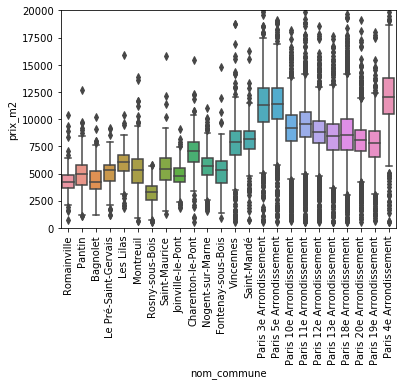

In [23]:
sns.boxplot(x="nom_commune", y="prix_m2", data=east_paris_transactions)
plt.ylim(0, 20000)
plt.xticks(rotation=90)
plt.autoscale(enable=True, axis='x')

So, depending on the cityes, median price go between **3000€/m²** and more than **12000€/m²**.

Let's take a look at the outliers, and simply drop them (prices per square meter above 20000€ or below 500€). The number of transactions we will keep per city is herebelow.

In [20]:
index_coll = east_paris_transactions[east_paris_transactions['prix_m2'] > 20000].index
index_coll = index_coll.append(east_paris_transactions[east_paris_transactions['prix_m2'] < 500].index)
east_paris_transactions = east_paris_transactions.drop(index_coll)
east_paris_transactions.reset_index(drop=True, inplace=True)
print(east_paris_transactions.shape)

east_paris_transactions.groupby(['code_postal', 'nom_commune'])['nombre_transactions'].sum()

(23367, 19)


code_postal  nom_commune             
75003        Paris 3e Arrondissement      760
75004        Paris 4e Arrondissement      524
75005        Paris 5e Arrondissement      824
75010        Paris 10e Arrondissement    1627
75011        Paris 11e Arrondissement    2561
75012        Paris 12e Arrondissement    1675
75013        Paris 13e Arrondissement    1576
75018        Paris 18e Arrondissement    3626
75019        Paris 19e Arrondissement    1829
75020        Paris 20e Arrondissement    2123
93100        Montreuil                   1035
93110        Rosny-sous-Bois              472
93170        Bagnolet                     312
93230        Romainville                  205
93260        Les Lilas                    275
93310        Le Pré-Saint-Gervais         198
93500        Pantin                       643
94120        Fontenay-sous-Bois           430
94130        Nogent-sur-Marne             572
94160        Saint-Mandé                  407
94220        Charenton-le-Pont            

#### To resume, we have now, in the dataframe east_paris_transactions the list of real estate transactions from 2018 in the cities of our choice, with the associated price / squere meter

#### This list contains approx. 23,000 transactions

### II.3 Divide geographical space in square tiles

Now let's analyse the geographical shape of our list of cities and divide this surface in a grid of 15x15 tiles.

In [24]:
bins_lat = np.linspace(min(east_paris_transactions['latitude']), max(east_paris_transactions['latitude']), 21)
lat_names = list(range(0,20))
east_paris_transactions['bins_lat'] = pd.cut(east_paris_transactions['latitude'], bins_lat, labels=lat_names, include_lowest=True)
bins_long = np.linspace(min(east_paris_transactions['longitude']), max(east_paris_transactions['longitude']), 21)
long_names = lat_names = list(range(0,20))
east_paris_transactions['bins_long'] = pd.cut(east_paris_transactions['longitude'], bins_long, labels=long_names, include_lowest=True)

east_paris_transactions.head()

id_mutation date_mutation nature_mutation  code_postal  nom_commune  \
0  2018-1195952    2018-01-03           Vente        93230  Romainville   
1  2018-1195953    2018-01-08           Vente        93500       Pantin   
2  2018-1195954    2018-01-05           Vente        93170     Bagnolet   
3  2018-1195955    2018-01-05           Vente        93500       Pantin   
4  2018-1195960    2018-01-05           Vente        93500       Pantin   

   adresse_numero   adresse_nom_voie  valeur_fonciere  longitude   latitude  \
0              25  BD EMILE GENEVOIX         230000.0   2.435743  48.881934   
1               4      RUE LAPEROUSE          90000.0   2.393240  48.900227   
2               2  RUE DES LORIETTES         222000.0   2.420057  48.872363   
3              31         RUE DELIZY         278000.0   2.408445  48.896071   
4             143     AV JEAN LOLIVE         695000.0   2.412250  48.893774   

   numero_disposition  surface_reelle_bati  Appartement  Dépendance  \
0                   2                 59.0            1           1   
1                   1                 40.0            1           0   
2                   1                 55.0            1           0   
3                   2                 52.0            1           1   
4                   3                107.0            1           2   

   Local industriel. commercial ou assimilé  Maison  \
0                                         0       0   
1                                         0       0   
2                                         0       0   
3                                         0       0   
4                                         0       0   

   nombre_pieces_principales  nombre_transactions      prix_m2 bins_lat  \
0                          3                    1  3898.305085       13   
1                          3                    1  2250.000000       17   
2                          3                    1  4036.363636       11   
3                          2                    1  5346.153846       16   
4                          5                    1  6495.327103       15   

  bins_long  
0        12  
1         7  
2        10  
3         9  
4         9

We will calculate now the average **price / square meter** and the **number of transactions** which occured in each tile.

In [25]:
tiles = east_paris_transactions.groupby(['bins_lat','bins_long'])['prix_m2'].mean().reset_index()
tiles.set_index(['bins_lat', 'bins_long'])

tiles2 = east_paris_transactions.groupby(['bins_lat','bins_long'])['nombre_transactions'].sum().reset_index()
tiles2.set_index(['bins_lat', 'bins_long'])

tiles= tiles.join(tiles2.set_index(['bins_lat', 'bins_long']), on=['bins_lat','bins_long'])
tiles = tiles.dropna().set_index(['bins_lat', 'bins_long']).reset_index()
tiles = tiles.astype({'nombre_transactions': 'int64'}, copy=False)
tiles.head()

bins_lat bins_long      prix_m2  nombre_transactions
0        0        14  4800.910964                   78
1        0        15  4983.057003                   82
2        0        16  4378.509903                    5
3        0        17  3992.873978                   11
4        1         1  7986.876643                    6

Let's enrich this tile list with the geographical information (latitude, longitude, square borders)

In [26]:
import time
#return a minimal address as a string from a raw location got from a geolocator
def get_address_from_geolocator (location):

    try:
        road = location['address']['road']
    except:
        try:
            road = location['address']['cycleway']
        except:
            try:
                road = location['address']['pedestrian']
            except:
                try:
                    road = location['address']['footway']
                except:
                    try:
                        road = location['address']['path']
                    except:
                        try:
                            road = location['address']['suburb']
                        except:
                            road = 'No road'
                            print('Warning, no road:', location)

    try:
        postcode = location['address']['postcode']
    except:
        postcode = 'No code'
        print('Warning, no code:',location)

    try:
        city = location['address']['city_district']
    except:
        try:
            city = location['address']['town']
        except:
            try:
                city = location['address']['city']
            except:
                city = 'No city'
                print('Warning, no city:', location)
            
    #   tiles.loc[i, 'tile_id'] = s
    address = "{}, {}, {}".format(road, postcode, city)
    return address

In [27]:
geolocator = Nominatim(user_agent="paris_explorer")

for lat in range(0, 20):
    index_list = tiles[tiles['bins_lat']==lat].index
    for k in index_list:
        tiles.at[k, 'lat_s'] = bins_lat[lat]
        tiles.at[k, 'lat_n'] = bins_lat[lat+1]
        tiles.at[k, 'latitude'] = (bins_lat[lat] + bins_lat[lat+1])/2

for long in range(0, 20):
    index_list = tiles[tiles['bins_long']==long].index
    for k in index_list:
        tiles.at[k, 'long_w'] = bins_long[long]
        tiles.at[k, 'long_e'] = bins_long[long+1]
        tiles.at[k, 'longitude'] = (bins_long[long] + bins_long[long+1])/2

for i in tiles.index:
    s = "{:02d}_{:02d}".format (tiles.loc[i, 'bins_lat'], tiles.loc[i, 'bins_long'],)
    tiles.loc[i, 'tile_id'] = s
    for j in range(0, 5):
        try:
            location = geolocator.reverse((tiles.loc[i,'latitude'], tiles.loc[i,'longitude']))
            break
        except:
            time.sleep(3)
    adr = get_address_from_geolocator(location.raw)
    tiles.loc[i, 'address'] = adr
    print(s, adr)
    
tiles.head()

00_14 Avenue de la Villa Antony, 94410, Saint-Maurice
00_15 Square de Presles, 94340, Joinville-le-Pont
00_16 Quai Beaubourg, 94100, Saint-Maur-des-Fossés
00_17 Rue Docteur Roux, 94500, Champigny-sur-Marne
01_01 Avenue Rockefeller, 75014, Paris 14e Arrondissement
01_02 Rue Thomire, 75013, Paris 13e Arrondissement
01_03 Boulevard Kellermann, 75013, Paris 13e Arrondissement
01_04 Boulevard Masséna, 75013, Paris 13e Arrondissement
01_08 Quai de Charenton, 75012, Paris 12e Arrondissement
01_09 Rue Victor Hugo, 94220, Charenton-le-Pont
01_10 Rue des Sureaux, 94410, Saint-Maurice
01_11 Rue Maurice Gredat, 94410, Saint-Maurice
01_12 Route Nouvelle, 75012, Paris 12e Arrondissement
01_13 Route de la Ferme, 75012, Paris 12e Arrondissement
01_14 Avenue de l'École de Joinville, 75012, Paris 12e Arrondissement
01_15 Rue Jean Mermoz, 94340, Joinville-le-Pont
01_16 Allée Raymond Nègre, 94340, Joinville-le-Pont
01_17 Avenue Roger Salengro, 94500, Champigny-sur-Marne
02_01 Avenue Reille, 75014, Paris 1

bins_lat bins_long      prix_m2  nombre_transactions      lat_s      lat_n  \
0        0        14  4800.910964                   78  48.811961  48.817117   
1        0        15  4983.057003                   82  48.811961  48.817117   
2        0        16  4378.509903                    5  48.811961  48.817117   
3        0        17  3992.873978                   11  48.811961  48.817117   
4        1         1  7986.876643                    6  48.817117  48.822273   

    latitude    long_w    long_e  longitude tile_id  \
0  48.814539  2.452674  2.461715   2.457194   00_14   
1  48.814539  2.461715  2.470756   2.466235   00_15   
2  48.814539  2.470756  2.479797   2.475277   00_16   
3  48.814539  2.479797  2.488838   2.484317   00_17   
4  48.819695  2.335141  2.344182   2.339662   01_01   

                                             address  
0    Avenue de la Villa Antony, 94410, Saint-Maurice  
1        Square de Presles, 94340, Joinville-le-Pont  
2       Quai Beaubourg, 94100, Saint-Maur-des-Fossés  
3       Rue Docteur Roux, 94500, Champigny-sur-Marne  
4  Avenue Rockefeller, 75014, Paris 14e Arrondiss...

Let's have a look of how these tiles map the list of cities and arrondissements we are interested in.

Prior, we will define a function **rectTile** which allows to create a json geometrical square object. Then, build a GeoJson file which contains the list of all our tiles.

In [28]:
def rectTile(tile_ids, long_w_list, long_e_list, lat_s_list, lat_n_list):
    
    tile_list=[]
    for tile_id, long_w, long_e, lat_s, lat_n,  in zip(tile_ids, long_w_list, long_e_list, lat_s_list, lat_n_list):
                 
        # print("tile_id ", tile_id)
        # return only relevant information for each nearby venue
        tile_list.append(
             {"type":"Feature",\
                "geometry":\
                  {"type":"Polygon",\
                     "coordinates":[[[long_w, lat_s],[long_w, lat_n],[long_e, lat_n],[long_e, lat_s]]]},\
                "properties":{"tile_id":tile_id}})
    return(tile_list)

east_tile_list = rectTile(tile_ids=tiles['tile_id'],
                                    long_w_list=tiles['long_w'],
                                    long_e_list=tiles['long_e'],
                                    lat_s_list=tiles['lat_s'],
                                    lat_n_list=tiles['lat_n']                                                                
                                  )

east_tiles = {"type":"FeatureCollection",\
"features": east_tile_list}

f = open('all_tiles.json', 'w')
json.dump(east_tiles, f)
f.close()

In [5]:
def paris_tiles (paris_map):
    workfile = r'all_tiles.json'
    print(workfile)

    folium.GeoJson(
        workfile
    ).add_to(paris_map)
    return (paris_map)

Now let's show the map, with the border of cities and the initial list of tiles we have built

In [6]:
paris_east_map = paris_east()

paris_east_map = paris_cities(paris_east_map)

paris_east_map = paris_tiles(paris_east_map)

paris_east_map

100% [............................................................................] 715186 / 715186all_tiles.json


On the top of that, center the circles in which we will look for Foursquera venues. The optimal radius seems to be 275 meters.

In [7]:
for lat, lon in zip(tiles['latitude'], tiles['longitude']):
    #print (lat, lon)
    folium.Circle([lat, lon], radius=275, color='blue', fill=False).add_to(paris_east_map)
paris_east_map

Looks good, but it is a little bit clumsy :-(

### II.4 Foursquera

In [34]:
# @hidden_cell
CLIENT_ID = 'WRGTBGWVIWD1S0LLK0GRGEARWM2GBYEQ1QOP0PSIPNBJHOUT' # your Foursquare ID
CLIENT_SECRET = 'VALOPUUYGGEAIWKNIW5WVQRIIGYRO2EZJ0LOTKT1JDXXECKF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

Now, let's get the venues for the list of tiles we have built

In [36]:
def getNearbyVenues(tile_ids, latitudes, longitudes, radius=550, LIMIT=100):
    
    venues_list=[]
    for tile_id, lat, lng in zip(tile_ids, latitudes, longitudes):
                 
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        #print(url)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        print("tile_id ", tile_id, ": ", len(results), " venues")
        # return only relevant information for each nearby venue
        venues_list.append([(
            tile_id,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['tile_id',
                  'Tile Latitude', 
                  'Tile Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

paris_east_venues = getNearbyVenues(tile_ids=tiles['tile_id'],
                                    latitudes=tiles['latitude'],
                                    longitudes=tiles['longitude']
                                  )
print(paris_east_venues.shape)
paris_east_venues.tail(20)

tile_id  00_14 :  6  venues
tile_id  00_15 :  11  venues
tile_id  00_16 :  5  venues
tile_id  00_17 :  2  venues
tile_id  01_01 :  21  venues
tile_id  01_02 :  20  venues
tile_id  01_03 :  35  venues
tile_id  01_04 :  50  venues
tile_id  01_08 :  12  venues
tile_id  01_09 :  4  venues
tile_id  01_10 :  5  venues
tile_id  01_11 :  1  venues
tile_id  01_12 :  5  venues
tile_id  01_13 :  6  venues
tile_id  01_14 :  5  venues
tile_id  01_15 :  9  venues
tile_id  01_16 :  7  venues
tile_id  01_17 :  4  venues
tile_id  02_01 :  25  venues
tile_id  02_02 :  61  venues
tile_id  02_03 :  99  venues
tile_id  02_04 :  97  venues
tile_id  02_05 :  43  venues
tile_id  02_07 :  31  venues
tile_id  02_08 :  23  venues
tile_id  02_09 :  20  venues
tile_id  02_10 :  5  venues
tile_id  02_15 :  9  venues
tile_id  02_16 :  6  venues
tile_id  03_01 :  34  venues
tile_id  03_02 :  72  venues
tile_id  03_03 :  74  venues
tile_id  03_04 :  40  venues
tile_id  03_05 :  50  venues
tile_id  03_06 :  40  venues


tile_id  Tile Latitude  Tile Longitude  \
8957   17_08      48.902195        2.402948   
8958   17_08      48.902195        2.402948   
8959   17_08      48.902195        2.402948   
8960   17_08      48.902195        2.402948   
8961   17_09      48.902195        2.411989   
8962   17_09      48.902195        2.411989   
8963   17_09      48.902195        2.411989   
8964   17_09      48.902195        2.411989   
8965   18_07      48.907351        2.393908   
8966   18_07      48.907351        2.393908   
8967   18_07      48.907351        2.393908   
8968   18_07      48.907351        2.393908   
8969   18_08      48.907351        2.402948   
8970   18_08      48.907351        2.402948   
8971   18_08      48.907351        2.402948   
8972   18_08      48.907351        2.402948   
8973   19_09      48.912507        2.411989   
8974   19_09      48.912507        2.411989   
8975   19_09      48.912507        2.411989   
8976   19_09      48.912507        2.411989   

                                  Venue  Venue Latitude  Venue Longitude  \
8957                    La Cité Fertile       48.898687         2.398871   
8958                     RER Pantin [E]       48.897989         2.400438   
8959                            Mondial       48.902135         2.406884   
8960                    L'Espace Pantin       48.897490         2.405078   
8961   Galerie Thaddaeus Ropac - Pantin       48.899350         2.408075   
8962                        Tang Frères       48.903145         2.417425   
8963                           Carglass       48.902950         2.416687   
8964                           Carglass       48.903108         2.416670   
8965                          KIngooroo       48.907874         2.395802   
8966  Sidi bousaïd (cuisine tunisienne)       48.904839         2.392877   
8967                       Chez Fernand       48.903219         2.395921   
8968     Sécuritest - Autodiag controle       48.910700         2.388400   
8969                        Halle Papin       48.904150         2.400839   
8970                             MurMur       48.902748         2.401252   
8971               In Situ Art Festival       48.911218         2.404677   
8972                          KIngooroo       48.907874         2.395802   
8973                 Boulangerie Louise       48.909757         2.412532   
8974                  Hotel B&B Bobigny       48.915527         2.417319   
8975                ASPTT Aubervilliers       48.915901         2.406920   
8976                             l'Etna       48.917182         2.410483   

                    Venue Category  
8957         General Entertainment  
8958                 Train Station  
8959                  Home Service  
8960             French Restaurant  
8961                   Art Gallery  
8962                   Supermarket  
8963             Other Repair Shop  
8964                   Auto Garage  
8965  Theme Park Ride / Attraction  
8966      Mediterranean Restaurant  
8967             French Restaurant  
8968                 Auto Workshop  
8969         Performing Arts Venue  
8970                  Climbing Gym  
8971                    Street Art  
8972  Theme Park Ride / Attraction  
8973                        Bakery  
8974                         Hotel  
8975                  Soccer Field  
8976                   Pizza Place

How many venues do we have?

A quick histogram will help to understand how many venues we have per tile.

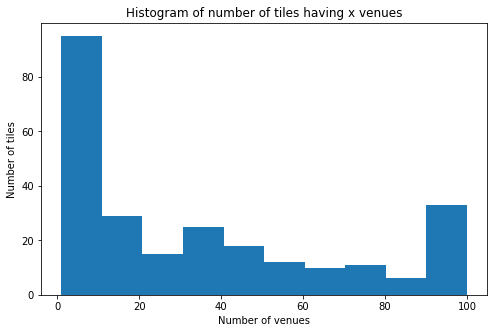

In [37]:
paris_east_venues['nombre_venues'] = 1
venues_per_tile = paris_east_venues.groupby(['tile_id','Tile Latitude', 'Tile Longitude'])['nombre_venues'].sum().reset_index()

# np.histogram returns 2 values
count, bin_edges = np.histogram(venues_per_tile['nombre_venues'])

#print(count) # frequency count
#print(bin_edges) # bin ranges, default = 10 bins

venues_per_tile['nombre_venues'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of number of tiles having x venues') # add a title to the histogram
plt.ylabel('Number of tiles') # add y-label
plt.xlabel('Number of venues') # add x-label

plt.show()

So, there are approx. 60 tiles on our area, having a very small (less than 10) number of interesting venues.

No let's add the number of venues to each tile of our **tiles** dataframe

In [38]:
tiles= tiles.join(venues_per_tile.set_index(['tile_id']), on=['tile_id'])
tiles.head()

bins_lat bins_long      prix_m2  nombre_transactions      lat_s      lat_n  \
0        0        14  4800.910964                   78  48.811961  48.817117   
1        0        15  4983.057003                   82  48.811961  48.817117   
2        0        16  4378.509903                    5  48.811961  48.817117   
3        0        17  3992.873978                   11  48.811961  48.817117   
4        1         1  7986.876643                    6  48.817117  48.822273   

    latitude    long_w    long_e  longitude tile_id  \
0  48.814539  2.452674  2.461715   2.457194   00_14   
1  48.814539  2.461715  2.470756   2.466235   00_15   
2  48.814539  2.470756  2.479797   2.475277   00_16   
3  48.814539  2.479797  2.488838   2.484317   00_17   
4  48.819695  2.335141  2.344182   2.339662   01_01   

                                             address  Tile Latitude  \
0    Avenue de la Villa Antony, 94410, Saint-Maurice      48.814539   
1        Square de Presles, 94340, Joinville-le-Pont      48.814539   
2       Quai Beaubourg, 94100, Saint-Maur-des-Fossés      48.814539   
3       Rue Docteur Roux, 94500, Champigny-sur-Marne      48.814539   
4  Avenue Rockefeller, 75014, Paris 14e Arrondiss...      48.819695   

   Tile Longitude  nombre_venues  
0        2.457194              6  
1        2.466235             11  
2        2.475277              5  
3        2.484317              2  
4        2.339662             21

We will drop the tiles which have less than 20 real estate transactions and less then 4 venues.

In [39]:
index_coll = tiles[tiles['nombre_transactions']<20].index
tiles=tiles.drop(index_coll)
tiles.reset_index(drop=True, inplace=True)
index_coll = tiles[tiles['nombre_venues']<4].index
tiles=tiles.drop(index_coll)
tiles.reset_index(drop=True, inplace=True)
tiles.head()

bins_lat bins_long      prix_m2  nombre_transactions      lat_s      lat_n  \
0        0        14  4800.910964                   78  48.811961  48.817117   
1        0        15  4983.057003                   82  48.811961  48.817117   
2        1         2  7698.852607                   29  48.817117  48.822273   
3        1         3  7285.351634                   38  48.817117  48.822273   
4        1         4  5929.060023                   45  48.817117  48.822273   

    latitude    long_w    long_e  longitude tile_id  \
0  48.814539  2.452674  2.461715   2.457194   00_14   
1  48.814539  2.461715  2.470756   2.466235   00_15   
2  48.819695  2.344182  2.353223   2.348702   01_02   
3  48.819695  2.353223  2.362264   2.357743   01_03   
4  48.819695  2.362264  2.371305   2.366784   01_04   

                                             address  Tile Latitude  \
0    Avenue de la Villa Antony, 94410, Saint-Maurice      48.814539   
1        Square de Presles, 94340, Joinville-le-Pont      48.814539   
2       Rue Thomire, 75013, Paris 13e Arrondissement      48.819695   
3  Boulevard Kellermann, 75013, Paris 13e Arrondi...      48.819695   
4  Boulevard Masséna, 75013, Paris 13e Arrondisse...      48.819695   

   Tile Longitude  nombre_venues  
0        2.457194              6  
1        2.466235             11  
2        2.348702             20  
3        2.357743             35  
4        2.366784             50

#### Our tiles dataframe contains now a list of geographical square zones, with the average price per square meter, the number of real estate transactions and the numbre of venues of interest for each tile

### II.5 Show real estate and number of venues on the same map

Our final part of the data analysis is to figure out - on the same map:
    - the average price per square meter
    - the number of venues
for all the tiles which cover our interest area

Let's rebuild our **east_tile_list** and generate a GeoJson file coresponding to the list of tiles of interest

In [40]:
east_tile_list = rectTile(tile_ids=tiles['tile_id'],
                                    long_w_list=tiles['long_w'],
                                    long_e_list=tiles['long_e'],
                                    lat_s_list=tiles['lat_s'],
                                    lat_n_list=tiles['lat_n']                                                                
                                  )

east_tile_list
east_tiles = {"type":"FeatureCollection",\
"features": east_tile_list}

f = open('east_tiles.json', 'w')

json.dump(east_tiles, f)

f.close()

Using a choropleth map, we will show the averag price per square meter in the various zones of interest

In [9]:
def paris_price_m2 (paris_map):

    workfile = r'east_tiles.json'
    print(workfile)

    folium.GeoJson(
        workfile
    ).add_to(paris_map)


    paris_map.choropleth(
        geo_data=workfile,
        data=tiles,
        columns=['tile_id', 'prix_m2'],
        key_on='feature.properties.tile_id',
        fill_color='YlOrRd', 
        fill_opacity=0.5, 
        line_opacity=0.2,
        legend_name='Real Estate price per square meter'
    )

    return paris_map

On the top of this we will add circle markers. The radius and color will represent the number of venues available in the tail (with a maximum of 100)

In [10]:
paris_east_map = paris_east()
paris_east_map = paris_price_m2 (paris_east_map)

# set color scheme for the clusters
x = np.arange(0,100)
ys = [i + x + (i*x)**2 for i in range(0,100)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



for lat, lng, nbv, nbt, prix, adr in zip(tiles['Tile Latitude'], tiles['Tile Longitude'], tiles['nombre_venues'], tiles['nombre_transactions'], tiles['prix_m2'], tiles['address']):
    label = '{:.0f} €/m2, {} transactions, {} venues, {}'.format(prix, nbt, nbv, adr)
    folium.CircleMarker(
        [lat, lng],
        radius=3+12*(nbv/100), # define how big you want the circle markers to be
       color=rainbow[nbv-1],
        fill=True,
       popup=label,
        fill_color=rainbow[nbv-1],
        fill_opacity=0.5
).add_to(paris_east_map)   
    

# display map
paris_east_map

east_tiles.json


D:\Python\WPy64-3741\python-3.7.4.amd64\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [11]:
ven_cat = paris_east_venues.groupby(['Venue Category'])['nombre_venues'].sum().reset_index()
ven_cat.head()

Venue Category  nombre_venues
0    Accessories Store              2
1    Afghan Restaurant              2
2   African Restaurant             34
3  Alsatian Restaurant              2
4  American Restaurant             22

In [44]:
paris_east_venues.to_csv('paris_east_venues_20.csv', index=False)
east_paris_transactions.to_csv('east_paris_transactions_20.csv', index=False)
tiles.to_csv('tiles_20.csv', index=False)

In [4]:
paris_east_venues = pd.read_csv('paris_east_venues_20.csv')
#paris_east_venues2.head(10)
tiles = pd.read_csv('tiles_20.csv')
#tiles2.head(10)
east_paris_transactions = pd.read_csv('east_paris_transactions_20.csv')
#east_paris_transactions2.head(10)

In [12]:
# one hot encoding
venues_onehot = pd.get_dummies(paris_east_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['tile_id'] = paris_east_venues['tile_id'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

print(venues_onehot.shape)
venues_onehot.head()

(8977, 354)


tile_id  Accessories Store  Afghan Restaurant  African Restaurant  \
0   00_14                  0                  0                   0   
1   00_14                  0                  0                   0   
2   00_14                  0                  0                   0   
3   00_14                  0                  0                   0   
4   00_14                  0                  0                   0   

   Alsatian Restaurant  American Restaurant  Amphitheater  Antique Shop  \
0                    0                    0             0             0   
1                    0                    0             0             0   
2                    0                    0             0             0   
3                    0                    0             0             0   
4                    0                    0             0             0   

   Aquarium  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0         0                 0                       0            0   
1         0                 0                       0            0   
2         0                 0                       0            0   
3         0                 0                       0            0   
4         0                 0                       0            0   

   Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    0                     0                 0   
3           0                    0                     0                 0   
4           0                    0                     0                 0   

   Athletics & Sports  Auto Dealership  Auto Garage  Auto Workshop  \
0                   0                0            0              0   
1                   0                0            0              0   
2                   0                0            0              0   
3                   0                0            0              0   
4                   0                0            0              0   

   Automotive Shop  Auvergne Restaurant  BBQ Joint  Baby Store  Bagel Shop  \
0                0                    0          0           0           0   
1                0                    0          0           0           0   
2                0                    0          0           0           0   
3                0                    0          0           0           0   
4                0                    0          0           0           0   

   Bakery  Bar  Baseball Stadium  Basketball Court  Basque Restaurant  Beach  \
0       0    0                 0                 0                  0      0   
1       0    0                 0                 0                  0      0   
2       0    0                 0                 0                  0      0   
3       0    0                 0                 0                  0      0   
4       0    0                 0                 0                  0      0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0                0         0            0           0              0   
1                0         0            0           0              0   
2                0         0            0           0              0   
3                0         0            0           0              0   
4                0         0            0           0              0   

   Bike Rental / Bike Share  Bistro  Board Shop  Boarding House  \
0                         0       0           0               0   
1                         0       0           0               0   
2                         0       0           0               0   
3                         0       0           0               0   
4                         0       0           0               0   

   Boat or Ferry  Bookstore

In [13]:
venues_grouped_sum = venues_onehot.groupby('tile_id').sum().reset_index()
venues_grouped_sum.head(10)

tile_id  Accessories Store  Afghan Restaurant  African Restaurant  \
0   00_14                  0                  0                   0   
1   00_15                  0                  0                   0   
2   00_16                  0                  0                   0   
3   00_17                  0                  0                   0   
4   01_01                  0                  0                   0   
5   01_02                  0                  0                   0   
6   01_03                  0                  0                   0   
7   01_04                  0                  0                   0   
8   01_08                  0                  0                   0   
9   01_09                  0                  0                   0   

   Alsatian Restaurant  American Restaurant  Amphitheater  Antique Shop  \
0                    0                    0             0             0   
1                    0                    0             0             0   
2                    0                    0             0             0   
3                    0                    0             0             0   
4                    0                    0             0             0   
5                    0                    0             0             0   
6                    0                    0             0             0   
7                    0                    0             0             0   
8                    0                    0             0             0   
9                    0                    0             0             0   

   Aquarium  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0         0                 0                       0            0   
1         0                 0                       0            0   
2         0                 0                       0            0   
3         0                 0                       0            0   
4         0                 0                       0            0   
5         0                 0                       0            0   
6         0                 0                       0            0   
7         0                 0                       0            0   
8         0                 0                       0            0   
9         0                 0                       0            0   

   Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    0                     0                 0   
3           0                    0                     0                 0   
4           0                    0                     0                 0   
5           0                    1                     0                 0   
6           0                    0                     0                 4   
7           0                    0                     0                 6   
8           0                    0                     0                 1   
9           0                    0                     0                 0   

   Athletics & Sports  Auto Dealership  Auto Garage  Auto Workshop  \
0                   0                0            0              0   
1                   0                0            0              0   
2                   0                0            0              0   
3                   0                0            0              0   
4                   0                0            0              0   
5                   0                0            0              0   
6                   0                0            0              0   
7                   0                0            0              0   
8                   0                0            0              0   
9                   0                0            0             

In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    row_categories_names = row_categories_sorted.index.values[0:num_top_venues]
    for k in range(0, num_top_venues):
        if row_categories_sorted[k] == 0:
            row_categories_names[k] = ''
        else:
            row_categories_names[k] = "{:.2f} {}".format(row_categories_sorted[k], row_categories_names[k])

    #print (row_categories_names)    
    
    #return row_categories_sorted.index.values[0:num_top_venues]
    return row_categories_names[0:num_top_venues]

In [15]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['tile_id', 'Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
tiles_venues_sorted = pd.DataFrame(columns=columns)
tiles_venues_sorted['tile_id'] = venues_grouped_sum['tile_id']

for ind in np.arange(venues_grouped_sum.shape[0]):
    tiles_venues_sorted.iloc[ind, 2:] = return_most_common_venues(venues_grouped_sum.iloc[ind, :], num_top_venues)

tiles_venues_sorted.head(10)

tile_id Cluster Labels       1st Most Common Venue  \
0   00_14            NaN                  1.00 Hotel   
1   00_15            NaN                  2.00 Hotel   
2   00_16            NaN         1.00 Farmers Market   
3   00_17            NaN             1.00 Laundromat   
4   01_01            NaN               2.00 Bus Stop   
5   01_02            NaN                  3.00 Plaza   
6   01_03            NaN  6.00 Vietnamese Restaurant   
7   01_04            NaN     8.00 Chinese Restaurant   
8   01_08            NaN   2.00 Fast Food Restaurant   
9   01_09            NaN              1.00 Laser Tag   

        2nd Most Common Venue           3rd Most Common Venue  \
0    1.00 Japanese Restaurant  1.00 Middle Eastern Restaurant   
1    2.00 Japanese Restaurant                     1.00 Market   
2      1.00 French Restaurant                      1.00 Hotel   
3            1.00 Supermarket                                   
4     2.00 Italian Restaurant                       2.00 Park   
5                2.00 Stadium                     2.00 Bakery   
6     5.00 Chinese Restaurant           4.00 Asian Restaurant   
7  7.00 Vietnamese Restaurant           6.00 Asian Restaurant   
8        1.00 Thai Restaurant          1.00 Mobile Phone Shop   
9                 1.00 Market                       1.00 Café   

       4th Most Common Venue      5th Most Common Venue  \
0           1.00 Supermarket                 1.00 Plaza   
1           1.00 Gas Station        1.00 Soccer Stadium   
2                1.00 Market            1.00 Playground   
3                                                         
4                   1.00 Pub         1.00 Train Station   
5    2.00 Chinese Restaurant      1.00 Football Stadium   
6  3.00 Cantonese Restaurant       2.00 Thai Restaurant   
7           5.00 Supermarket  3.00 Cantonese Restaurant   
8      1.00 Asian Restaurant                1.00 Lounge   
9           1.00 Supermarket                              

       6th Most Common Venue      7th Most Common Venue  \
0           1.00 Pizza Place                              
1  1.00 Gym / Fitness Center           1.00 Supermarket   
2                                                         
3                                                         
4             1.00 Brasserie     1.00 French Restaurant   
5   1.00 Arts & Crafts Store                   1.00 Pub   
6    2.00 Italian Restaurant  2.00 Cambodian Restaurant   
7                 2.00 Hotel                 2.00 Plaza   
8             1.00 Laser Tag         1.00 Boat or Ferry   
9                                                         

       8th Most Common Venue      9th Most Common Venue  \
0                                                         
1            1.00 Smoke Shop           1.00 Pizza Place   
2                                                         
3                                                         
4          1.00 Squash Court               1.00 Stadium   
5              1.00 Bus Stop                  1.00 Café   
6                  2.00 Park                 2.00 Hotel   
7  2.00 Cambodian Restaurant       2.00 Thai Restaurant   
8  1.00 Gym / Fitness Center  1.00 Caribbean Restaurant   
9                                                         

  10th Most Common Venue         11th Most Common Venue  \
0                                                         
1                                                         
2                                                         
3                                                         
4  1.00 Doner Restaurant                    1.00 Bakery   
5            1.00 Garden             1.00 Grocery Store   
6            1.00 Bakery  1.00 Bike Rental / Bike Share   
7     2.00 Grocery Store               2.00 Pastry Shop   
8             1.00 Hotel               1.00 Gas Station   
9                                                         

  12th Most Common Venue   13th Most Common Venue     14th Most Commo

In [16]:
# set number of clusters
kclusters = 12

tiles_grouped_clustering = venues_grouped_sum.drop('tile_id', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(tiles_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:200] 

array([ 0,  0,  0,  0,  0,  8,  8,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  8,  7,  9,  9, 11,  8,  8,  8,  0,  0,  0,  8,  1,  2, 11, 11,
        8,  0,  0,  0,  0,  0, 11,  3,  3, 11, 11,  2, 11, 11,  8,  0,  0,
        0,  0,  8, 11,  3,  2,  8,  2,  2, 11, 11,  0,  0,  0,  0,  0,  0,
        0,  3,  4,  2,  3,  4,  1, 11, 11, 11,  2, 11, 11,  0,  0,  0,  0,
        0,  0,  6,  6,  4,  2,  5,  4,  1,  1,  8,  2,  8,  8,  0,  0,  0,
        0,  8,  6, 10, 10,  5,  1,  1,  1,  8, 11,  8,  8,  0,  0,  0,  0,
        0,  0, 10, 10, 10,  4,  7,  1,  2,  8,  0,  0,  8,  0,  0,  0,  0,
        0,  0, 10, 10, 10,  5,  7,  7,  2,  8,  8,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 10, 10, 10,  7,  7,  7,  8,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  4, 10,  1,  7,  1,  7,  8,  8,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  3,  4,  4, 11,  2,  2,  2,  8])

In [17]:
# add clustering labels
#tiles_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
tiles_venues_sorted['Cluster Labels'] = kmeans.labels_

tiles_merged = tiles
# merge tiles_merged with tiles_venues_sorted to add latitude/longitude for Cluster and most common venues for each tile
tiles_merged = tiles_merged.join(tiles_venues_sorted.set_index('tile_id'), on='tile_id')
tiles_merged.head(10) # check the last columns!

bins_lat  bins_long      prix_m2  nombre_transactions      lat_s  \
0         0         14  4800.910964                   78  48.811961   
1         0         15  4983.057003                   82  48.811961   
2         1          2  7698.852607                   29  48.817117   
3         1          3  7285.351634                   38  48.817117   
4         1          4  5929.060023                   45  48.817117   
5         1          9  6216.823028                  119  48.817117   
6         1         10  6838.099303                  109  48.817117   
7         1         15  4857.885471                   61  48.817117   
8         1         16  4906.013236                   45  48.817117   
9         2          1  8921.586504                   54  48.822273   

       lat_n   latitude    long_w    long_e  longitude tile_id  \
0  48.817117  48.814539  2.452674  2.461715   2.457194   00_14   
1  48.817117  48.814539  2.461715  2.470756   2.466235   00_15   
2  48.822273  48.819695  2.344182  2.353223   2.348703   01_02   
3  48.822273  48.819695  2.353223  2.362264   2.357744   01_03   
4  48.822273  48.819695  2.362264  2.371305   2.366785   01_04   
5  48.822273  48.819695  2.407469  2.416510   2.411990   01_09   
6  48.822273  48.819695  2.416510  2.425551   2.421031   01_10   
7  48.822273  48.819695  2.461715  2.470756   2.466235   01_15   
8  48.822273  48.819695  2.470756  2.479797   2.475277   01_16   
9  48.827430  48.824852  2.335141  2.344182   2.339662   02_01   

                                             address  Tile Latitude  \
0    Avenue de la Villa Antony, 94410, Saint-Maurice      48.814539   
1        Square de Presles, 94340, Joinville-le-Pont      48.814539   
2       Rue Thomire, 75013, Paris 13e Arrondissement      48.819695   
3  Boulevard Kellermann, 75013, Paris 13e Arrondi...      48.819695   
4  Boulevard Masséna, 75013, Paris 13e Arrondisse...      48.819695   
5          Rue Victor Hugo, 94220, Charenton-le-Pont      48.819695   
6              Rue des Sureaux, 94410, Saint-Maurice      48.819695   
7          Rue Jean Mermoz, 94340, Joinville-le-Pont      48.819695   
8      Allée Raymond Nègre, 94340, Joinville-le-Pont      48.819695   
9     Avenue Reille, 75014, Paris 14e Arrondissement      48.824852   

   Tile Longitude  nombre_venues  Cluster Labels       1st Most Common Venue  \
0        2.457194              6               0                  1.00 Hotel   
1        2.466235             11               0                  2.00 Hotel   
2        2.348703             20               8                  3.00 Plaza   
3        2.357744             35               8  6.00 Vietnamese Restaurant   
4        2.366785             50               8     8.00 Chinese Restaurant   
5        2.411990              4               0              1.00 Laser Tag   
6        2.421031              5               0             1.00 Canal Lock   
7        2.466235              9               0      1.00 French Restaurant   
8        2.475277              7               0                  2.00 Hotel   
9        2.339662             25               8                 2.00 Bakery   

        2nd Most Common Venue           3rd Most Common Venue  \
0    1.00 Japanese Restaurant  1.00 Middle Eastern Restaurant   
1    2.00 Japanese Restaurant                     1.00 Market   
2                2.00 Stadium                     2.00 Bakery   
3     5.00 Chinese Restaurant           4.00 Asian Restaurant   
4  7.00 Vietnamese Restaurant           6.00 Asian Restaurant   
5                 1.00 Market                       1.00 Café   
6                  1.00 Hotel                       1.00 Café   
7            1.00 Gas Station                      1.00 Beach   
8   1.00 Fast Food Restaurant                        1.00 Pub   
9               2.00 Bus Stop         2.00 Italian Restaurant   

       4th Most Common Venue           5th Most Common Venue  \
0           1.00 Supermarket                      1

In [18]:
venues_grouped_cluster = venues_grouped_sum
venues_grouped_cluster = venues_grouped_cluster.join(tiles_merged[['tile_id', 'Cluster Labels', 'nombre_venues']].set_index('tile_id'), on='tile_id')
venues_grouped_cluster = venues_grouped_cluster.dropna().reset_index(drop=True)
venues_grouped_cluster = venues_grouped_cluster.astype({'Cluster Labels': 'int64'}, copy=False)
venues_grouped_cluster = venues_grouped_cluster.astype({'nombre_venues': 'int64'}, copy=False)
venues_grouped_cluster.head(10)

tile_id  Accessories Store  Afghan Restaurant  African Restaurant  \
0   00_14                  0                  0                   0   
1   00_15                  0                  0                   0   
2   01_02                  0                  0                   0   
3   01_03                  0                  0                   0   
4   01_04                  0                  0                   0   
5   01_09                  0                  0                   0   
6   01_10                  0                  0                   0   
7   01_15                  0                  0                   0   
8   01_16                  0                  0                   0   
9   02_01                  0                  0                   0   

   Alsatian Restaurant  American Restaurant  Amphitheater  Antique Shop  \
0                    0                    0             0             0   
1                    0                    0             0             0   
2                    0                    0             0             0   
3                    0                    0             0             0   
4                    0                    0             0             0   
5                    0                    0             0             0   
6                    0                    0             0             0   
7                    0                    0             0             0   
8                    0                    0             0             0   
9                    0                    0             0             0   

   Aquarium  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0         0                 0                       0            0   
1         0                 0                       0            0   
2         0                 0                       0            0   
3         0                 0                       0            0   
4         0                 0                       0            0   
5         0                 0                       0            0   
6         0                 0                       0            0   
7         0                 0                       0            0   
8         0                 0                       0            0   
9         0                 0                       0            0   

   Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    1                     0                 0   
3           0                    0                     0                 4   
4           0                    0                     0                 6   
5           0                    0                     0                 0   
6           0                    0                     0                 0   
7           0                    0                     0                 0   
8           0                    0                     0                 0   
9           0                    0                     0                 0   

   Athletics & Sports  Auto Dealership  Auto Garage  Auto Workshop  \
0                   0                0            0              0   
1                   0                0            0              0   
2                   0                0            0              0   
3                   0                0            0              0   
4                   0                0            0              0   
5                   0                0            0              0   
6                   0                0            0              0   
7                   0                0            0              0   
8                   0                0            0              0   
9                   0                0            0             

In [19]:
cluster_grouped_mean = venues_grouped_cluster.drop('tile_id',1).groupby('Cluster Labels').mean().reset_index()
cluster_grouped_mean

Cluster Labels  Accessories Store  Afghan Restaurant  African Restaurant  \
0                0           0.000000           0.000000            0.016129   
1                1           0.000000           0.000000            0.214286   
2                2           0.000000           0.000000            0.333333   
3                3           0.000000           0.000000            0.000000   
4                4           0.000000           0.100000            0.300000   
5                5           0.333333           0.000000            0.666667   
6                6           0.000000           0.000000            0.000000   
7                7           0.000000           0.111111            0.555556   
8                8           0.000000           0.000000            0.093750   
9                9           0.000000           0.000000            0.000000   
10              10           0.000000           0.000000            0.454545   
11              11           0.000000           0.000000            0.136364   

    Alsatian Restaurant  American Restaurant  Amphitheater  Antique Shop  \
0              0.000000             0.048387      0.016129           0.0   
1              0.000000             0.214286      0.000000           0.0   
2              0.000000             0.266667      0.000000           0.0   
3              0.000000             0.600000      0.000000           0.0   
4              0.000000             0.200000      0.000000           0.1   
5              0.000000             0.000000      0.000000           0.0   
6              0.500000             0.000000      0.000000           0.0   
7              0.000000             0.000000      0.000000           0.0   
8              0.000000             0.062500      0.000000           0.0   
9              0.000000             0.000000      0.000000           0.0   
10             0.090909             0.000000      0.000000           0.0   
11             0.000000             0.136364      0.000000           0.0   

    Aquarium  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0   0.000000          0.000000                0.016129     0.048387   
1   0.000000          0.071429                0.214286     0.142857   
2   0.000000          0.000000                0.066667     0.000000   
3   0.000000          0.000000                0.000000     0.000000   
4   0.000000          0.100000                0.200000     0.300000   
5   0.000000          0.000000                0.000000     0.666667   
6   0.000000          0.000000                0.500000     1.000000   
7   0.000000          0.000000                0.111111     0.000000   
8   0.031250          0.000000                0.031250     0.062500   
9   0.000000          0.000000                0.000000     0.000000   
10  0.000000          0.000000                0.272727     2.000000   
11  0.045455          0.000000                0.000000     0.181818   

    Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0     0.000000             0.016129              0.016129          0.048387   
1     0.142857             0.214286              0.000000          0.642857   
2     0.066667             0.000000              0.000000          0.800000   
3     0.200000             0.000000              0.000000          0.400000   
4     0.600000             0.200000              0.000000          0.300000   
5     0.000000             0.000000              0.000000          1.000000   
6     0.000000             0.000000              0.000000          0.000000   
7     0.111111             0.111111              0.000000          0.777778   
8     0.000000             0.031250              0.000000          0.468750   
9     0.000000             0.000000              0.000000         13.000000   
10    0.454545             0.181818              0.000000          0.909091   
11    0.045455             0.090909              0.000000          0.500000   

    Athletics & Sports

In [20]:
cluster_labels_sorted = cluster_grouped_mean[['Cluster Labels', 'nombre_venues']].sort_values(['nombre_venues']).reset_index(drop=True)
cluster_labels_sorted

dict_cluster_rename = dict(zip(cluster_labels_sorted['Cluster Labels'], cluster_labels_sorted.index ))
dict_cluster_rename

{0: 0, 8: 1, 11: 2, 2: 3, 7: 4, 1: 5, 3: 6, 4: 7, 5: 8, 9: 9, 10: 10, 6: 11}

In [21]:
venues_grouped_cluster['Cluster Labels'].replace(to_replace=dict_cluster_rename, inplace=True)
tiles_venues_sorted['Cluster Labels'].replace(to_replace=dict_cluster_rename, inplace=True)
tiles_merged['Cluster Labels'].replace(to_replace=dict_cluster_rename, inplace=True)

In [22]:
cluster_grouped_mean['Cluster Labels'].replace(to_replace=dict_cluster_rename, inplace=True)
cluster_grouped_mean

Cluster Labels  Accessories Store  Afghan Restaurant  African Restaurant  \
0                0           0.000000           0.000000            0.016129   
1                5           0.000000           0.000000            0.214286   
2                3           0.000000           0.000000            0.333333   
3                6           0.000000           0.000000            0.000000   
4                7           0.000000           0.100000            0.300000   
5                8           0.333333           0.000000            0.666667   
6               11           0.000000           0.000000            0.000000   
7                4           0.000000           0.111111            0.555556   
8                1           0.000000           0.000000            0.093750   
9                9           0.000000           0.000000            0.000000   
10              10           0.000000           0.000000            0.454545   
11               2           0.000000           0.000000            0.136364   

    Alsatian Restaurant  American Restaurant  Amphitheater  Antique Shop  \
0              0.000000             0.048387      0.016129           0.0   
1              0.000000             0.214286      0.000000           0.0   
2              0.000000             0.266667      0.000000           0.0   
3              0.000000             0.600000      0.000000           0.0   
4              0.000000             0.200000      0.000000           0.1   
5              0.000000             0.000000      0.000000           0.0   
6              0.500000             0.000000      0.000000           0.0   
7              0.000000             0.000000      0.000000           0.0   
8              0.000000             0.062500      0.000000           0.0   
9              0.000000             0.000000      0.000000           0.0   
10             0.090909             0.000000      0.000000           0.0   
11             0.000000             0.136364      0.000000           0.0   

    Aquarium  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0   0.000000          0.000000                0.016129     0.048387   
1   0.000000          0.071429                0.214286     0.142857   
2   0.000000          0.000000                0.066667     0.000000   
3   0.000000          0.000000                0.000000     0.000000   
4   0.000000          0.100000                0.200000     0.300000   
5   0.000000          0.000000                0.000000     0.666667   
6   0.000000          0.000000                0.500000     1.000000   
7   0.000000          0.000000                0.111111     0.000000   
8   0.031250          0.000000                0.031250     0.062500   
9   0.000000          0.000000                0.000000     0.000000   
10  0.000000          0.000000                0.272727     2.000000   
11  0.045455          0.000000                0.000000     0.181818   

    Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0     0.000000             0.016129              0.016129          0.048387   
1     0.142857             0.214286              0.000000          0.642857   
2     0.066667             0.000000              0.000000          0.800000   
3     0.200000             0.000000              0.000000          0.400000   
4     0.600000             0.200000              0.000000          0.300000   
5     0.000000             0.000000              0.000000          1.000000   
6     0.000000             0.000000              0.000000          0.000000   
7     0.111111             0.111111              0.000000          0.777778   
8     0.000000             0.031250              0.000000          0.468750   
9     0.000000             0.000000              0.000000         13.000000   
10    0.454545             0.181818              0.000000          0.909091   
11    0.045455             0.090909              0.000000          0.500000   

    Athletics & Sports

In [23]:
cluster_grouped_mean = cluster_grouped_mean.sort_values(['Cluster Labels']).reset_index(drop=True)
cluster_grouped_mean

Cluster Labels  Accessories Store  Afghan Restaurant  African Restaurant  \
0                0           0.000000           0.000000            0.016129   
1                1           0.000000           0.000000            0.093750   
2                2           0.000000           0.000000            0.136364   
3                3           0.000000           0.000000            0.333333   
4                4           0.000000           0.111111            0.555556   
5                5           0.000000           0.000000            0.214286   
6                6           0.000000           0.000000            0.000000   
7                7           0.000000           0.100000            0.300000   
8                8           0.333333           0.000000            0.666667   
9                9           0.000000           0.000000            0.000000   
10              10           0.000000           0.000000            0.454545   
11              11           0.000000           0.000000            0.000000   

    Alsatian Restaurant  American Restaurant  Amphitheater  Antique Shop  \
0              0.000000             0.048387      0.016129           0.0   
1              0.000000             0.062500      0.000000           0.0   
2              0.000000             0.136364      0.000000           0.0   
3              0.000000             0.266667      0.000000           0.0   
4              0.000000             0.000000      0.000000           0.0   
5              0.000000             0.214286      0.000000           0.0   
6              0.000000             0.600000      0.000000           0.0   
7              0.000000             0.200000      0.000000           0.1   
8              0.000000             0.000000      0.000000           0.0   
9              0.000000             0.000000      0.000000           0.0   
10             0.090909             0.000000      0.000000           0.0   
11             0.500000             0.000000      0.000000           0.0   

    Aquarium  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0   0.000000          0.000000                0.016129     0.048387   
1   0.031250          0.000000                0.031250     0.062500   
2   0.045455          0.000000                0.000000     0.181818   
3   0.000000          0.000000                0.066667     0.000000   
4   0.000000          0.000000                0.111111     0.000000   
5   0.000000          0.071429                0.214286     0.142857   
6   0.000000          0.000000                0.000000     0.000000   
7   0.000000          0.100000                0.200000     0.300000   
8   0.000000          0.000000                0.000000     0.666667   
9   0.000000          0.000000                0.000000     0.000000   
10  0.000000          0.000000                0.272727     2.000000   
11  0.000000          0.000000                0.500000     1.000000   

    Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0     0.000000             0.016129              0.016129          0.048387   
1     0.000000             0.031250              0.000000          0.468750   
2     0.045455             0.090909              0.000000          0.500000   
3     0.066667             0.000000              0.000000          0.800000   
4     0.111111             0.111111              0.000000          0.777778   
5     0.142857             0.214286              0.000000          0.642857   
6     0.200000             0.000000              0.000000          0.400000   
7     0.600000             0.200000              0.000000          0.300000   
8     0.000000             0.000000              0.000000          1.000000   
9     0.000000             0.000000              0.000000         13.000000   
10    0.454545             0.181818              0.000000          0.909091   
11    0.000000             0.000000              0.000000          0.000000   

    Athletics & Sports

In [24]:
paris_east_map = paris_east()
paris_east_map = paris_price_m2 (paris_east_map)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster, nbv in zip(tiles_merged['Tile Latitude'], tiles_merged['Tile Longitude'], tiles_merged['Cluster Labels'], tiles_merged['nombre_venues']):
    label = 'Cluster C{}; Nb_venues: {}'.format(cluster, nbv)
    folium.CircleMarker(
        [lat, lon],
        radius=3+12*(nbv/100), # define how big you want the circle markers to be
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
        ).add_to(paris_east_map)
       
paris_east_map

east_tiles.json


D:\Python\WPy64-3741\python-3.7.4.amd64\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [25]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels', 'Total venues']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cluster_venues_sorted = pd.DataFrame(columns=columns)
cluster_venues_sorted['Cluster Labels'] = cluster_grouped_mean['Cluster Labels']
cluster_venues_sorted['Total venues'] = cluster_grouped_mean['nombre_venues']
print(cluster_venues_sorted.shape)

for ind in np.arange(cluster_grouped_mean.shape[0]):
   cluster_venues_sorted.iloc[ind, 2:] = return_most_common_venues(cluster_grouped_mean.iloc[ind, :-1], num_top_venues)

cluster_venues_sorted.head(12)

(12, 17)


Cluster Labels  Total venues        1st Most Common Venue  \
0                0      8.096774             0.53 Supermarket   
1                1     27.062500       1.78 French Restaurant   
2                2     43.500000       3.86 French Restaurant   
3                3     58.400000       6.93 French Restaurant   
4                4     63.888889                    10.33 Bar   
5                5     72.000000      11.21 French Restaurant   
6                6     80.000000      11.40 French Restaurant   
7                7     96.200000      18.20 French Restaurant   
8                8     97.666667      11.67 French Restaurant   
9                9     98.000000  18.00 Vietnamese Restaurant   
10              10     99.454545       9.55 French Restaurant   
11              11    100.000000      12.50 French Restaurant   

     2nd Most Common Venue    3rd Most Common Venue     4th Most Common Venue  \
0               0.37 Hotel  0.35 Italian Restaurant    0.32 French Restaurant   
1         1.38 Supermarket               1.31 Hotel                1.00 Plaza   
2               3.23 Hotel                1.86 Café  1.77 Japanese Restaurant   
3               3.13 Hotel                 2.80 Bar   2.07 Italian Restaurant   
4   5.89 French Restaurant          2.67 Restaurant                 2.67 Café   
5                 6.57 Bar  3.00 Italian Restaurant                 2.93 Café   
6              10.00 Hotel                 3.40 Bar   3.20 Italian Restaurant   
7               5.40 Hotel  4.70 Italian Restaurant                  4.40 Bar   
8                10.33 Bar        5.33 Cocktail Bar               4.67 Bistro   
9   13.00 Asian Restaurant     9.00 Thai Restaurant   8.00 Chinese Restaurant   
10              4.45 Hotel         4.09 Coffee Shop          3.27 Pizza Place   
11              7.00 Plaza                 3.50 Bar          3.00 Coffee Shop   

      5th Most Common Venue     6th Most Common Venue  \
0                 0.26 Park  0.26 Japanese Restaurant   
1               1.00 Bakery                 0.91 Café   
2          1.64 Supermarket               1.55 Bakery   
3               1.93 Bakery                 1.73 Café   
4               2.33 Bistro   1.89 Chinese Restaurant   
5               2.71 Bistro  2.43 Japanese Restaurant   
6                 2.80 Café               2.40 Bakery   
7               3.90 Bakery             2.90 Wine Bar   
8   4.33 Italian Restaurant             3.33 Wine Bar   
9    5.00 French Restaurant                3.00 Hotel   
10              3.00 Bakery   3.00 Italian Restaurant   
11              3.00 Bistro                3.00 Hotel   

        7th Most Common Venue  8th Most Common Venue  \
0                  0.23 Plaza  0.21 Sushi Restaurant   
1     0.72 Chinese Restaurant               0.66 Bar   
2                 1.50 Bistro               1.45 Bar   
3                  1.67 Plaza       1.53 Supermarket   
4                 1.78 Bakery             1.67 Plaza   
5            2.21 Pizza Place             2.00 Hotel   
6        1.60 Thai Restaurant  1.60 Sushi Restaurant   
7            2.60 Coffee Shop            2.10 Bistro   
8             2.67 Restaurant         2.67 Bookstore   
9   3.00 Cantonese Restaurant            2.50 Bakery   
10            2.82 Restaurant          2.64 Wine Bar   
11                3.00 Bakery    3.00 Ice Cream Shop   

        9th Most Common Venue      10th Most Common Venue  \
0             0.21 Restaurant            0.21 Pizza Place   
1   0.62 Fast Food Restaurant    0.62 Japanese Restaurant   
2     1.27 Italian Restaurant            1.05 Pizza Place   
3                 1.47 Bistro             1.47 Restaurant   
4     1.44 Italian Restaurant  1.44 Vietnamese Restaurant   
5             1.71 Restaurant        1.57 Thai Restaurant   
6         1.60 Sandwich Place    1.40 Japanese Restaurant   
7                   2.10 Café                  1.90 Plaza   
8                 2.33 Bakery            2.33 Pizza Place   
9              2.50 Jui

In [26]:
cluster_venues_sorted.to_csv('cluster_20_12_rand4.csv')

In [27]:
tiles_merged.head()

bins_lat  bins_long      prix_m2  nombre_transactions      lat_s  \
0         0         14  4800.910964                   78  48.811961   
1         0         15  4983.057003                   82  48.811961   
2         1          2  7698.852607                   29  48.817117   
3         1          3  7285.351634                   38  48.817117   
4         1          4  5929.060023                   45  48.817117   

       lat_n   latitude    long_w    long_e  longitude tile_id  \
0  48.817117  48.814539  2.452674  2.461715   2.457194   00_14   
1  48.817117  48.814539  2.461715  2.470756   2.466235   00_15   
2  48.822273  48.819695  2.344182  2.353223   2.348703   01_02   
3  48.822273  48.819695  2.353223  2.362264   2.357744   01_03   
4  48.822273  48.819695  2.362264  2.371305   2.366785   01_04   

                                             address  Tile Latitude  \
0    Avenue de la Villa Antony, 94410, Saint-Maurice      48.814539   
1        Square de Presles, 94340, Joinville-le-Pont      48.814539   
2       Rue Thomire, 75013, Paris 13e Arrondissement      48.819695   
3  Boulevard Kellermann, 75013, Paris 13e Arrondi...      48.819695   
4  Boulevard Masséna, 75013, Paris 13e Arrondisse...      48.819695   

   Tile Longitude  nombre_venues  Cluster Labels       1st Most Common Venue  \
0        2.457194              6               0                  1.00 Hotel   
1        2.466235             11               0                  2.00 Hotel   
2        2.348703             20               1                  3.00 Plaza   
3        2.357744             35               1  6.00 Vietnamese Restaurant   
4        2.366785             50               1     8.00 Chinese Restaurant   

        2nd Most Common Venue           3rd Most Common Venue  \
0    1.00 Japanese Restaurant  1.00 Middle Eastern Restaurant   
1    2.00 Japanese Restaurant                     1.00 Market   
2                2.00 Stadium                     2.00 Bakery   
3     5.00 Chinese Restaurant           4.00 Asian Restaurant   
4  7.00 Vietnamese Restaurant           6.00 Asian Restaurant   

       4th Most Common Venue      5th Most Common Venue  \
0           1.00 Supermarket                 1.00 Plaza   
1           1.00 Gas Station        1.00 Soccer Stadium   
2    2.00 Chinese Restaurant      1.00 Football Stadium   
3  3.00 Cantonese Restaurant       2.00 Thai Restaurant   
4           5.00 Supermarket  3.00 Cantonese Restaurant   

       6th Most Common Venue      7th Most Common Venue  \
0           1.00 Pizza Place                              
1  1.00 Gym / Fitness Center           1.00 Supermarket   
2   1.00 Arts & Crafts Store                   1.00 Pub   
3    2.00 Italian Restaurant  2.00 Cambodian Restaurant   
4                 2.00 Hotel                 2.00 Plaza   

       8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
0                                                                           
1            1.00 Smoke Shop      1.00 Pizza Place                          
2              1.00 Bus Stop             1.00 Café            1.00 Garden   
3                  2.00 Park            2.00 Hotel            1.00 Bakery   
4  2.00 Cambodian Restaurant  2.00 Thai Restaurant     2.00 Grocery Store   

          11th Most Common Venue 12th Most Common Venue  \
0                                                         
1                                                         
2             1.00 Grocery Store      1.00 Tram Station   
3  1.00 Bike Rental / Bike Share     1.00 Grocery Store   
4               2.00 Pastry Shop      1.00 Tram Station   

  13th Most Common Venue     14th Most Common Venue 15th Most Common Venue  
0                                                                           
1                                                                           
2              1.00 Park   1.00 Japanese Restaurant       1.00 Pizza Place  
3     1.00 Metro Station  1.00 Gym / Fitness

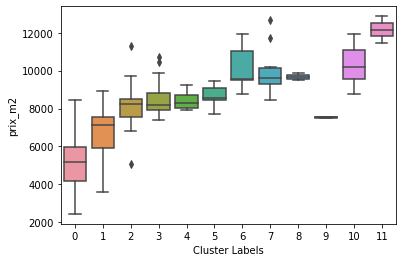

In [28]:
sns.boxplot(x="Cluster Labels", y="prix_m2", data=tiles_merged)
#plt.ylim(0, 20000)
#plt.xticks(rotation=90)
plt.autoscale(enable=True, axis='x')

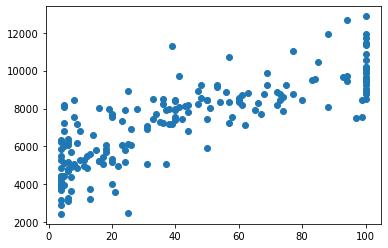

In [29]:
plt.scatter(x=tiles_merged['nombre_venues'], y=tiles_merged['prix_m2'])
plt.show()

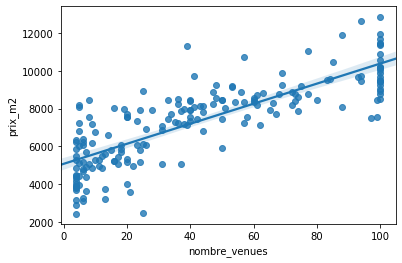

In [30]:
sns.regplot(x=tiles_merged['nombre_venues'], y=tiles_merged['prix_m2'])

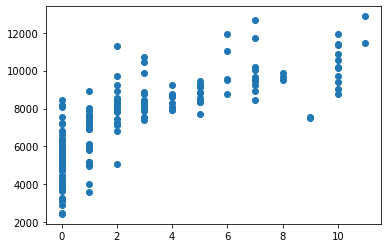

In [31]:
plt.scatter(x=tiles_merged['Cluster Labels'], y=tiles_merged['prix_m2'])
plt.show()

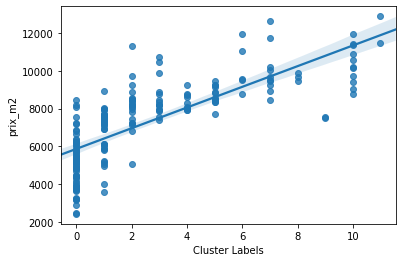

In [32]:
sns.regplot(x=tiles_merged['Cluster Labels'], y=tiles_merged['prix_m2'])


In [33]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(tiles_merged[['nombre_venues']])
y = np.asanyarray(tiles_merged[['prix_m2']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Coefficients: ', regr.intercept_)
print('Variance score: %.2f' % regr.score(x, y))

Coefficients:  [[53.08744818]]
Coefficients:  [5077.82474301]
Variance score: 0.65


In [34]:
regr = linear_model.LinearRegression()
x = np.asanyarray(tiles_merged[['Cluster Labels']])
y = np.asanyarray(tiles_merged[['prix_m2']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Coefficients: ', regr.intercept_)
print('Variance score: %.2f' % regr.score(x, y))

Coefficients:  [[547.27597546]]
Coefficients:  [5862.5579672]
Variance score: 0.59


In [35]:
regr = linear_model.LinearRegression()
x = np.asanyarray(tiles_merged[['Cluster Labels', 'nombre_venues']])
y = np.asanyarray(tiles_merged[['prix_m2']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Coefficients: ', regr.intercept_)
print('Variance score: %.2f' % regr.score(x, y))

Coefficients:  [[86.71641423 45.64507281]]
Coefficients:  [5161.06362424]
Variance score: 0.65


In [36]:
# one hot encoding
clist = list("C{:02d}".format(k) for k in list (venues_grouped_cluster['Cluster Labels']))

cluster_onehot = pd.get_dummies(clist, prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cluster_onehot['tile_id'] = venues_grouped_cluster['tile_id']
cluster_onehot['nombre_venues'] = venues_grouped_cluster['nombre_venues']


# move neighborhood column to the first column
#fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
#venues_onehot = venues_onehot[fixed_columns]

#print(cluster_onehot.shape)
cluster_onehot.head()

C00  C01  C02  C03  C04  C05  C06  C07  C08  C09  C10  C11 tile_id  \
0    1    0    0    0    0    0    0    0    0    0    0    0   00_14   
1    1    0    0    0    0    0    0    0    0    0    0    0   00_15   
2    0    1    0    0    0    0    0    0    0    0    0    0   01_02   
3    0    1    0    0    0    0    0    0    0    0    0    0   01_03   
4    0    1    0    0    0    0    0    0    0    0    0    0   01_04   

   nombre_venues  
0              6  
1             11  
2             20  
3             35  
4             50

In [37]:
venues_grouped_cluster.merge(cluster_onehot, on='tile_id').head()

tile_id  Accessories Store  Afghan Restaurant  African Restaurant  \
0   00_14                  0                  0                   0   
1   00_15                  0                  0                   0   
2   01_02                  0                  0                   0   
3   01_03                  0                  0                   0   
4   01_04                  0                  0                   0   

   Alsatian Restaurant  American Restaurant  Amphitheater  Antique Shop  \
0                    0                    0             0             0   
1                    0                    0             0             0   
2                    0                    0             0             0   
3                    0                    0             0             0   
4                    0                    0             0             0   

   Aquarium  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0         0                 0                       0            0   
1         0                 0                       0            0   
2         0                 0                       0            0   
3         0                 0                       0            0   
4         0                 0                       0            0   

   Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    1                     0                 0   
3           0                    0                     0                 4   
4           0                    0                     0                 6   

   Athletics & Sports  Auto Dealership  Auto Garage  Auto Workshop  \
0                   0                0            0              0   
1                   0                0            0              0   
2                   0                0            0              0   
3                   0                0            0              0   
4                   0                0            0              0   

   Automotive Shop  Auvergne Restaurant  BBQ Joint  Baby Store  Bagel Shop  \
0                0                    0          0           0           0   
1                0                    0          0           0           0   
2                0                    0          0           0           0   
3                0                    0          0           0           0   
4                0                    0          0           0           0   

   Bakery  Bar  Baseball Stadium  Basketball Court  Basque Restaurant  Beach  \
0       0    0                 0                 0                  0      0   
1       0    0                 0                 0                  0      0   
2       2    0                 0                 0                  0      0   
3       1    0                 0                 0                  0      0   
4       0    0                 0                 0                  0      0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0                0         0            0           0              0   
1                0         0            0           0              0   
2                0         0            0           0              0   
3                1         0            0           0              0   
4                1         0            0           0              0   

   Bike Rental / Bike Share  Bistro  Board Shop  Boarding House  \
0                         0       0           0               0   
1                         0       0           0               0   
2                         0       0           0               0   
3                         1       0           0               0   
4                         0       0           0               0   

   Boat or Ferry  Bookstore

In [51]:
X_features = venues_grouped_cluster.drop(['Cluster Labels', 'nombre_venues'], 1).set_index('tile_id')
#X_features = venues_grouped_cluster[['tile_id', 'nombre_venues']].set_index('tile_id')
#X_features = venues_grouped_cluster.merge(cluster_onehot, on='tile_id').drop(['Cluster Labels', 'nombre_venues_x', 'nombre_venues_y'], 1).set_index('tile_id')
#X_features = cluster_onehot.drop(['nombre_venues'], 1).set_index('tile_id')
X_features.head()

Accessories Store  Afghan Restaurant  African Restaurant  \
tile_id                                                             
00_14                    0                  0                   0   
00_15                    0                  0                   0   
01_02                    0                  0                   0   
01_03                    0                  0                   0   
01_04                    0                  0                   0   

         Alsatian Restaurant  American Restaurant  Amphitheater  Antique Shop  \
tile_id                                                                         
00_14                      0                    0             0             0   
00_15                      0                    0             0             0   
01_02                      0                    0             0             0   
01_03                      0                    0             0             0   
01_04                      0                    0             0             0   

         Aquarium  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
tile_id                                                                    
00_14           0                 0                       0            0   
00_15           0                 0                       0            0   
01_02           0                 0                       0            0   
01_03           0                 0                       0            0   
01_04           0                 0                       0            0   

         Art Museum  Arts & Crafts Store  Arts & Entertainment  \
tile_id                                                          
00_14             0                    0                     0   
00_15             0                    0                     0   
01_02             0                    1                     0   
01_03             0                    0                     0   
01_04             0                    0                     0   

         Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Garage  \
tile_id                                                                       
00_14                   0                   0                0            0   
00_15                   0                   0                0            0   
01_02                   0                   0                0            0   
01_03                   4                   0                0            0   
01_04                   6                   0                0            0   

         Auto Workshop  Automotive Shop  Auvergne Restaurant  BBQ Joint  \
tile_id                                                                   
00_14                0                0                    0          0   
00_15                0                0                    0          0   
01_02                0                0                    0          0   
01_03                0                0                    0          0   
01_04                0                0                    0          0   

         Baby Store  Bagel Shop  Bakery  Bar  Baseball Stadium  \
tile_id                                                          
00_14             0           0       0    0                 0   
00_15             0           0       0    0                 0   
01_02             0           0       2    0                 0   
01_03             0           0       1    0                 0   
01_04             0           0       0    0                 0   

         Basketball Court  Basque Restaurant  Beach  Bed & Breakfast  \
tile_id                                                                
00_14                   0                  0      0                0   
00_15                   0                  0      0                0   
01_02                   0                  0      0                0   
01_03                   0                  0      0       

In [52]:
X_columns = pd.DataFrame(data={'Venue type':list(X_features.columns)})
X_columns.tail()

Venue type
348    Wings Joint
349  Women's Store
350    Yoga Studio
351            Zoo
352    Zoo Exhibit

In [53]:
Y = tiles_merged[['tile_id', 'prix_m2']].set_index('tile_id')
Y.head()

prix_m2
tile_id             
00_14    4800.910964
00_15    4983.057003
01_02    7698.852607
01_03    7285.351634
01_04    5929.060023

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, Y, test_size=0.30, random_state=42)

In [55]:
regr = linear_model.Ridge(alpha=10)
#x = np.asanyarray(venues_grouped_cluster.drop(['tile_id', 'Cluster Labels', 'nombre_venues'], 1))
#y = np.asanyarray(tiles_merged[['prix_m2']])
regr.fit (X_train, y_train)
# The coefficients
#print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)
print('Variance score train: %.2f' % regr.score(X_train, y_train))
print('Variance score test: %.2f' % regr.score(X_test, y_test))

X_columns['Coefficients'] = regr.coef_[0]
X_columns.head()

Intercept:  [4867.62613543]
Variance score train: 0.91
Variance score test: 0.59


Venue type  Coefficients
0    Accessories Store    -18.172003
1    Afghan Restaurant      0.000000
2   African Restaurant     -6.163387
3  Alsatian Restaurant     16.747902
4  American Restaurant   -143.826395

In [56]:
X_columns.sort_values(by=['Coefficients'])


Venue type  Coefficients
45                                  Brasserie   -311.528922
149                               Golf Course   -296.446796
112                         Electronics Store   -268.597790
206                  Mediterranean Restaurant   -232.930398
296                            Soccer Stadium   -224.675944
287                                Shoe Store   -220.621209
143                               Gas Station   -208.438131
155                                  Gym Pool   -195.090234
165                              Home Service   -190.352551
346                                  Wine Bar   -180.439837
218                           Motorcycle Shop   -172.307080
284                        Seafood Restaurant   -168.274469
23                                 Bagel Shop   -158.784285
135                       Fried Chicken Joint   -156.506860
121                      Fast Food Restaurant   -152.198087
4                         American Restaurant   -143.826395
139                    Furniture / Home Store   -142.011150
199                                 Locksmith   -136.564643
278                            Sandwich Place   -134.492393
170                                 Hotel Bar   -126.713154
336                             Train Station   -115.099348
97                               Dance Studio   -113.635241
43                              Bowling Alley   -111.341700
266                            Rental Service   -110.806083
245                                  Pharmacy   -110.153862
213                         Mobile Phone Shop   -108.523006
88                          Convenience Store   -106.759137
274                                 Roof Deck   -106.536004
295                              Soccer Field   -105.033283
152                             Grocery Store   -104.178895
92                            Coworking Space   -103.279593
200                                    Lounge   -102.668385
242                              Perfume Shop   -100.988576
138                              Funeral Home   -100.563417
78                               Climbing Gym   -100.326482
24                                     Bakery    -95.640623
15                         Athletics & Sports    -89.457461
57                           Business Service    -88.893489
103                                     Diner    -87.465816
105                                  Dive Bar    -86.894897
12                        Arts & Crafts Store    -84.403908
265                       Rental Car Location    -83.644818
98                              Deli / Bodega    -82.757901
236                         Outdoor Sculpture    -81.624599
83                                Comedy Club    -81.533032
326                                   Theater    -79.313737
58                                    Butcher    -76.546427
79                             Clothing Store    -75.879272
348                               Wings Joint    -75.289573
21                                  BBQ Joint    -73.807326
146                     General Entertainment    -72.873636
106                                 Dive Spot    -72.390853
341                          Video Game Store    -72.250257
347                                 Wine Shop    -71.938746
28                          Basque Restaurant    -67.632022
172                            Ice Cream Shop    -62.383402
203                                    Market    -57.120296
159                   Health & Beauty Service    -55.403042
102                        Dim Sum Restaurant    -50.204242
299           Southern / Soul Food Restaurant    -48.566526
168                             Hot Dog Joint    -48.566526
107                          Doner Restaurant    -47.381974
177                              Intersection    -47.071080
8                            Arepa Restaurant    -45.142845
343                                  Vineyard    -45.142845
340             Vegetarian / Vegan Restaurant    -43.664161
171            

In [ ]:
tiles_merged[tiles_merged['Cluster Labels']==0].head(10)

As a first conclusion of this Data Analysis section, it seems that we have a **direct correlation** beteween the **real estate price per square meter** in a zone and the **number of venues on interest** in the same region.

A more detailed analysis will follow in the next sections

## III. Methodology <a name="methodology"></a>

## IV. Analysis <a name="analysis"></a>

## V. Results and Discussion <a name="results"></a>

## VI. Conclusion <a name="conclusion"></a>

## Appendices

In [ ]:
east_paris_cities= east_paris_transactions.groupby(['code_postal', 'nom_commune'])['prix_m2'].median().reset_index()
east_paris_cities.insert(loc=len(east_paris_cities.columns), column='latitude', value=0.0)
east_paris_cities.insert(loc=len(east_paris_cities.columns), column='longitude', value=0.0)